In [1]:
# %%
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import rasterio as rio
import xarray as xr
import rioxarray
import json
import requests
from pyproj import CRS
import pyproj
from osgeo import gdal
from math import ceil, floor
import matplotlib.pyplot as plt
from odc.stac import stac_load
import planetary_computer
import pystac_client
import rich.table
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression

# %%
###### CHANGE HERE ###########
network_name = "Oklahoma"
minx = -98.58786
miny = 33.82133
maxx = -97.04978
maxy = 34.995094
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# 0:[-98.58786217637618,33.821335388212596]
# 1:[-97.04977623887618,33.821335388212596]
# 2:[-97.04977623887618,34.995093659391095]
# 3:[-98.58786217637618,34.995093659391095]
# 4:[-98.58786217637618,33.821335388212596]

startDate = datetime(2016, 1, 1)
endDate = datetime(2021, 9, 30)
currentDate = startDate

###### CHANGE HERE ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"


In [2]:
def load_SMAPL4_precip(bbox=None, currentDate=None):

    SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data
    minx = bbox['minx']
    maxx = bbox['maxx']
    miny = bbox['miny']
    maxy = bbox['maxy']

    # Loop for 3 hourly data
    for SMAPL4_time in SMAPL4_times: 

        ### Some notes ###
        # open_rasterio is fast, as it is lazy load
        # https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.open_rasterio

        # Y axis accidentally flipped when loading data. The following solution suggested in stackoverflow did not work :(
        # ds_SMAPL4 = ds_SMAPL4.reindex(y=ds_SMAPL4.y*(-1))
        # ds_SMAPL4 = ds_SMAPL4.isel(y=slice(None, None, -1)).copy()
        #################

        # Check files
        fn = os.path.join(input_path, SMAPL4_path, f'SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv7032_001_HEGOUT.nc')
        if not os.path.exists(fn):
            fn = os.path.join(input_path, SMAPL4_path, f'SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv7030_001_HEGOUT.nc')
            if not os.path.exists(fn):
                print(f'File does not exist SMAP_L4_SM_gph_{currentDate.strftime("%Y%m%d")}T{SMAPL4_time}00_Vv703x_001_HEGOUT.nc')

        # Open dataset and clip to the area of interest
        ds_SMAPL4 = rioxarray.open_rasterio(fn)
        ds_SMAPL4_clipped = ds_SMAPL4.rio.clip_box(minx=minx, miny=maxy*(-1), maxx=maxx, maxy=miny*(-1)).copy()
        ds_SMAPL4_clipped_array = ds_SMAPL4_clipped['precipitation_total_surface_flux'][0].values
        ds_SMAPL4_clipped_array[ds_SMAPL4_clipped_array==-9999] = np.nan

        # Stack up to get daily values 
        if not 'ds_SMAPL4_stack' in locals():
            ds_SMAPL4_stack = ds_SMAPL4_clipped_array
        else: 
            ds_SMAPL4_stack = np.dstack((ds_SMAPL4_stack, ds_SMAPL4_clipped_array))

        y_coord = ds_SMAPL4_clipped.y.values * (-1)
        x_coord = ds_SMAPL4_clipped.x.values

        del ds_SMAPL4_clipped_array, ds_SMAPL4, ds_SMAPL4_clipped

    # Get daily average precipitation field
    ds_SMAPL4_avg = np.nanmean(ds_SMAPL4_stack, axis=2)

    # Create new dataarray with data corrected for the flipped y axis
    ds_SMAPL4_P = xr.DataArray(
                data = ds_SMAPL4_avg,
                dims=['y', 'x'],
                coords=dict(
                    y = y_coord,
                    x = x_coord,
                    time = currentDate
                    )
            )
    ds_SMAPL4_P.rio.write_crs('epsg:4326', inplace=True) 
    del ds_SMAPL4_stack, ds_SMAPL4_avg, x_coord, y_coord

    return ds_SMAPL4_P

In [97]:
# Loop for the timeperiod
delta = timedelta(days=1)
data_list = []
currentDate = startDate
while currentDate <= endDate:
    print(currentDate)
    try:
        data_list.append(load_SMAPL4_precip(bbox=bbox, currentDate=currentDate))
    except:
        currentDate += delta
        continue
    currentDate += delta

2016-01-01 00:00:00
2016-01-02 00:00:00
2016-01-03 00:00:00
2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-09 00:00:00
2016-01-10 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-16 00:00:00
2016-01-17 00:00:00
2016-01-18 00:00:00
2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-23 00:00:00
2016-01-24 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-01-30 00:00:00
2016-01-31 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-06 00:00:00
2016-02-07 00:00:00
2016-02-08 00:00:00
2016-02-09 00:00:00
2016-02-10 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-13 00:00:00
2016-02-14 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00


UnboundLocalError: local variable 'ds_SMAPL4_stack' referenced before assignment

In [100]:
stacked_ds_SMAPL4_P = xr.concat(data_list, dim='time')
stacked_ds_SMAPL4_P

<xarray.DataArray (time: 2100, y: 8, x: 11)>
array([[[6.56101547e-05, 6.14931487e-05, 5.73696925e-05, ...,
         1.09699526e-04, 1.31880341e-04, 1.52659137e-04],
        [6.41201841e-05, 5.85189846e-05, 5.29047829e-05, ...,
         1.21333287e-04, 1.44403428e-04, 1.65047124e-04],
        [6.08006121e-05, 5.46676783e-05, 4.85344717e-05, ...,
         1.29679509e-04, 1.51305518e-04, 1.69826671e-04],
        ...,
        [3.82161925e-05, 3.78707082e-05, 3.75299969e-05, ...,
         1.23517457e-04, 1.25580700e-04, 1.25668768e-04],
        [3.34391952e-05, 3.64883053e-05, 3.95481256e-05, ...,
         1.05728992e-04, 1.03374594e-04, 1.01795478e-04],
        [2.87521889e-05, 3.51703966e-05, 4.15932045e-05, ...,
         8.52159792e-05, 7.87572935e-05, 7.57605012e-05]],

       [[5.68965625e-05, 3.93356240e-05, 2.17573397e-05, ...,
         6.88453270e-07, 7.23088078e-07, 2.44998319e-06],
        [3.88000408e-05, 2.52743412e-05, 1.17332238e-05, ...,
         3.79894345e-07, 4.06605523e-07, 2.10541157e-06],
        [3.28161332e-05, 2.02929823e-05, 7.76114939e-06, ...,
         1.53339556e-07, 1.70761382e-07, 1.67609073e-06],
...
        [1.28731132e-04, 1.23642385e-04, 1.18557364e-04, ...,
         2.31403857e-04, 2.48510391e-04, 2.42169946e-04],
        [1.36192888e-04, 1.30226836e-04, 1.24253333e-04, ...,
         2.19676644e-04, 2.37938017e-04, 2.36261636e-04],
        [1.44744292e-04, 1.37794763e-04, 1.30832195e-04, ...,
         2.13969499e-04, 2.33922154e-04, 2.37032771e-04]],

       [[9.78503376e-05, 1.14737079e-04, 1.31614506e-04, ...,
         2.48795026e-04, 2.89585092e-04, 2.77898274e-04],
        [9.02265310e-05, 1.03360042e-04, 1.16509385e-04, ...,
         2.36064137e-04, 2.75923871e-04, 2.68963689e-04],
        [8.10222700e-05, 9.09706578e-05, 1.00931153e-04, ...,
         2.20218906e-04, 2.57746491e-04, 2.55729188e-04],
        ...,
        [4.40981239e-05, 4.88567166e-05, 5.36229927e-05, ...,
         1.60906464e-04, 1.85970217e-04, 1.98217109e-04],
        [3.37248202e-05, 3.78477853e-05, 4.19712160e-05, ...,
         1.73052773e-04, 2.04371288e-04, 2.18574889e-04],
        [2.35729385e-05, 2.70716846e-05, 3.05735739e-05, ...,
         1.87058933e-04, 2.25029886e-04, 2.41321512e-04]]], dtype=float32)
Coordinates:
  * y            (y) float64 -35.89 -35.8 -35.7 -35.61 ... -35.42 -35.33 -35.24
  * x            (x) float64 147.3 147.4 147.5 147.6 ... 147.9 148.0 148.1 148.2
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-09-30
    spatial_ref  int32 0

In [101]:
stacked_ds_SMAPL4_P.to_netcdf(path='test_SMAPL4.nc')

In [2]:
def load_SMAPL3_SM(bbox=None, currentDate=None):
    
    minx = bbox['minx']
    maxx = bbox['maxx']
    miny = bbox['miny']
    maxy = bbox['maxy']

    # Load file 
    fn = os.path.join(input_path, SMAPL3_path, f'SMAP_L3_SM_P_E_{currentDate.strftime("%Y%m%d")}_R18290_001_HEGOUT.nc')
    if not os.path.exists(fn):
        fn = os.path.join(input_path, SMAPL3_path, f'SMAP_L3_SM_P_E_{currentDate.strftime("%Y%m%d")}_R18290_002_HEGOUT.nc')
        if not os.path.exists(fn):
            fn = os.path.join(input_path, SMAPL3_path, f'SMAP_L3_SM_P_E_{currentDate.strftime("%Y%m%d")}_R18290_003_HEGOUT.nc')
            if not os.path.exists(fn):
                print(f'The file does not exist: {fn}')
    ds_SMAPL3_0 = rioxarray.open_rasterio(fn)

    # Clip and mask data using quality flag
    # Thankfully the y axis is not flipped for SMAPL3 dataset
    ds_SMAPL3_clipped = ds_SMAPL3_0.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy).copy()
    mask_am = (ds_SMAPL3_clipped.retrieval_qual_flag == 0) | (ds_SMAPL3_clipped.retrieval_qual_flag == 8)
    ds_SMAPL3_am = ds_SMAPL3_clipped['soil_moisture'].where(mask_am).copy()
    mask_pm = (ds_SMAPL3_clipped.retrieval_qual_flag_pm == 0) | (ds_SMAPL3_clipped.retrieval_qual_flag_pm == 8)
    ds_SMAPL3_pm = ds_SMAPL3_clipped['soil_moisture_pm'].where(mask_pm).copy()
    del mask_am, mask_pm

    # Concatenate AM and PM data, take average between AM and PM data, and assign a time coordinate
    ds_SMAPL3 = xr.concat([ds_SMAPL3_am, ds_SMAPL3_pm], dim='band').mean(dim='band', skipna=True).assign_coords({"time": currentDate})
    del ds_SMAPL3_am, ds_SMAPL3_pm

    return ds_SMAPL3

In [3]:
delta = timedelta(days=1)
data_list = []
currentDate = startDate
while currentDate <= endDate:
    print(currentDate)
    try:
        data_list.append(load_SMAPL3_SM(bbox=bbox, currentDate=currentDate))
    except:
        currentDate += delta
        continue
    currentDate += delta
stacked_ds_SMAPL3_SM = xr.concat(data_list, dim='time')

2016-01-01 00:00:00
2016-01-02 00:00:00
2016-01-03 00:00:00
2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-09 00:00:00
2016-01-10 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-16 00:00:00
2016-01-17 00:00:00
2016-01-18 00:00:00
2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-23 00:00:00
2016-01-24 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-01-30 00:00:00
2016-01-31 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-06 00:00:00
2016-02-07 00:00:00
2016-02-08 00:00:00
2016-02-09 00:00:00
2016-02-10 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-13 00:00:00
2016-02-14 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00


In [7]:
# stacked_ds_SMAPL3_SM
# stacked_ds_SMAPL3_SM.rio.write_crs('epsg:4326', inplace=True) 
# stacked_ds_SMAPL3_SM.to_netcdf(path='test_SMAPL3.nc')

KeyError: '/crs'

In [8]:
def load_singer_PET(bbox, currentYear):
    
    minx = bbox['minx']
    maxx = bbox['maxx']
    miny = bbox['miny']
    maxy = bbox['maxy']
    
    fn = os.path.join(input_path, PET_path, f'{currentYear}_daily_pet.nc')
    if not os.path.exists(fn):
        print(f'The file does not exist: {fn}')
    
    ds_PET_0 = rioxarray.open_rasterio(fn)
    ds_PET_0.rio.write_crs('epsg:4326', inplace=True)
    ds_PET_clipped = ds_PET_0.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy).copy()
    
    return ds_PET_clipped

In [9]:
delta = 1
data_list = []
currentYear = startDate.year
while currentYear <= endDate.year:
    print(currentYear)
    data_list.append(load_singer_PET(bbox=bbox, currentYear=currentYear))
    currentYear += 1

stacked_ds_PET = xr.concat(data_list, dim='time')

2016
2017
2018
2019
2020
2021


In [10]:
stacked_ds_PET.to_netcdf(path='test_PET.nc')

In [14]:
# Reload nc files if needed
stacked_ds_SMAPL4_P = rioxarray.open_rasterio('test_SMAPL4.nc')
# stacked_ds_SMAPL4_P.sel(time='2016-01-01').values

array([[[2.87521889e-05, 3.51703966e-05, 4.15932045e-05, 5.60848057e-05,
         7.26990984e-05, 8.93284086e-05, 9.98463220e-05, 9.16728168e-05,
         8.52159792e-05, 7.87572935e-05, 7.57605012e-05],
        [3.34391952e-05, 3.64883053e-05, 3.95481256e-05, 5.38618842e-05,
         7.43881537e-05, 9.49368259e-05, 1.09402950e-04, 1.08090891e-04,
         1.05728992e-04, 1.03374594e-04, 1.01795478e-04],
        [3.82161925e-05, 3.78707082e-05, 3.75299969e-05, 5.24107818e-05,
         7.61475676e-05, 9.98902906e-05, 1.17836782e-04, 1.21469362e-04,
         1.23517457e-04, 1.25580700e-04, 1.25668768e-04],
        [4.44134675e-05, 4.17542105e-05, 3.90835630e-05, 5.17448207e-05,
         7.33911875e-05, 9.50558315e-05, 1.12932103e-04, 1.22496334e-04,
         1.30342174e-04, 1.38139265e-04, 1.42856035e-04],
        [5.16196123e-05, 4.73715299e-05, 4.31220942e-05, 5.16368309e-05,
         6.74890180e-05, 8.33700833e-05, 9.87108433e-05, 1.14921233e-04,
         1.29486201e-04, 1.44050515e-0

In [41]:
def synthesize_data(i, j, lon, lat):
    # 2d da -> 1d df for SMAP and P data 
    SM1d = stacked_ds_SMAPL3_SM.isel(x=i, y=j)
    P1d = stacked_ds_SMAPL4_P.sel(x=lon, y=lat, method='nearest')
    PET1d = stacked_ds_PET.sel(x=lon, y=lat, method='nearest')
    df_SM = SM1d.to_pandas()
    df_P = P1d.to_pandas()
    df_PET = PET1d.to_dataframe()

    # Standardize column names
    df_SM.name = 'soil_moisture_smapL3'
    df_P.name = 'precip'
    # df_SM.set_index(df_SM.index.to_datetimeindex(), inplace=True)
    df_P = df_P.reindex(df_P.index.to_datetimeindex())
    df_PET.set_index(df_PET.index.to_datetimeindex(), inplace=True)
    # df_SM.index.name = 'time'
    df_P.index.name = 'time'
    df_PET.index.name = 'time'

    # Synthesize all the data
    df_synced = pd.merge(df_SM, df_P, on='time')
    df_synced = pd.merge(df_synced, df_PET['pet'], on='time')
    df_synced['noprecip'] = df_synced['precip'] < 0.00002
    df_synced.drop(df_synced.index[(df_synced['noprecip']==True) & (df_synced['soil_moisture_smapL3'].isnull())], inplace=True)
    df_synced['dt'] = df_synced.index.to_series().diff().dt.days.values
    df_synced['dSdt'] = df_synced['soil_moisture_smapL3'].diff() / df_synced['dt']
    df_synced['dSdt'][df_synced['dSdt']>0] = np.nan
    df_synced['dSdt(t+1)'] = df_synced['dSdt'].shift(periods=-1).copy()

    quantile_thresh = 10
    if quantile_thresh == 10:
        df_synced['PET_quantile']  = pd.qcut(df_synced['pet'][df_synced['noprecip']], 10, labels=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    elif quantile_thresh == 20:
        df_synced['PET_quantile']  = pd.qcut(df_synced['pet'][df_synced['noprecip']], 5, labels=[20, 40, 60, 80, 100])
    
    return df_synced

In [42]:
def fit_linear_line(x, y, forced_intercept_x, weight_regression=True, plot_results=False):
    ## Using Scikit learn

    # Shift x values by forced_intercept_x
    new_x = x - forced_intercept_x
    new_x = new_x.reshape((-1,1))

    # Linear regression wighout weight
    model = LinearRegression(fit_intercept=False).fit(new_x, y)

    # r = model.score(new_x_upper,y_upper)
    a = model.coef_
    b = -1 * a * forced_intercept_x
    
    if not weight_regression:
        a_out = a
        b_out = b

    if weight_regression:
        # Residuals
        residuals = y - (a*x+b)

        # Linear regression with weight
        model_weighted = LinearRegression(fit_intercept=False).fit(new_x, y, sample_weight=1/residuals**2)
        a_weighted = model_weighted.coef_
        b_weighted = -1 * a_weighted * forced_intercept_x
        a_out = a_weighted
        b_out = b_weighted
        
    if plot_results:
        plt.plot(x,y,'o')
        plt.plot(x,a_out*x+b_out)
        plt.show()
        
    return a_out, b_out

In [43]:
def calc_corr_strength_PET_Ltheta(df_synced):
    quantile_thresh = 10
    x_upper = df_synced['soil_moisture_smapL3'][df_synced['PET_quantile']==100].values
    y_upper = df_synced['dSdt(t+1)'][df_synced['PET_quantile']==100].values *-1
    nans_upper = np.isnan(x_upper) | np.isnan(y_upper)

    x_lower = df_synced['soil_moisture_smapL3'][df_synced['PET_quantile']==quantile_thresh].values
    y_lower = df_synced['dSdt(t+1)'][df_synced['PET_quantile']==quantile_thresh].values *-1
    nans_lower = np.isnan(x_lower) | np.isnan(y_lower)

    x_upper = np.delete(x_upper, nans_upper)
    y_upper = np.delete(y_upper, nans_upper)
    x_lower = np.delete(x_lower, nans_lower)
    y_lower = np.delete(y_lower, nans_lower)

    forced_intercept = df_synced['soil_moisture_smapL3'].min()
    try:
        m_upper, b_upper = fit_linear_line(x=x_upper, y=y_upper, forced_intercept_x=forced_intercept, plot_results=False)
        m_lower, b_lower = fit_linear_line(x=x_lower, y=y_lower, forced_intercept_x=forced_intercept, plot_results=False)
        diff_m = m_upper[0]-m_lower[0]
    except:
        diff_m = np.nan

    return diff_m

In [48]:
print(len(stacked_ds_SMAPL3_SM.y.values), len(stacked_ds_SMAPL3_SM.x.values))
diff_m_array = np.empty((len(stacked_ds_SMAPL3_SM.y.values), len(stacked_ds_SMAPL3_SM.x.values)),)
diff_m_array[:] = np.nan


9 11


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [49]:
for i, lon in enumerate(stacked_ds_SMAPL3_SM.x.values):
    print(f'Currently processing {i+1}/{len(stacked_ds_SMAPL3_SM.x.values)}')
    for j, lat in enumerate(stacked_ds_SMAPL3_SM.y.values):
        print(f'Currently processing {j+1}/{len(stacked_ds_SMAPL3_SM.y.values)}')
        try:
            df_synced = synthesize_data(i, j, lon, lat)
            diff_m_array[j][i] = calc_corr_strength_PET_Ltheta(df_synced)
        except:
            continue

Currently processing 1/11
Currently processing 1/9
Currently processing 2/9
Currently processing 3/9
Currently processing 4/9
Currently processing 5/9
Currently processing 6/9
Currently processing 7/9
Currently processing 8/9
Currently processing 9/9
Currently processing 2/11
Currently processing 1/9
Currently processing 2/9
Currently processing 3/9
Currently processing 4/9
Currently processing 5/9
Currently processing 6/9
Currently processing 7/9
Currently processing 8/9
Currently processing 9/9
Currently processing 3/11
Currently processing 1/9
Currently processing 2/9
Currently processing 3/9
Currently processing 4/9
Currently processing 5/9
Currently processing 6/9
Currently processing 7/9
Currently processing 8/9
Currently processing 9/9
Currently processing 4/11
Currently processing 1/9
Currently processing 2/9
Currently processing 3/9
Currently processing 4/9
Currently processing 5/9
Currently processing 6/9
Currently processing 7/9
Currently processing 8/9
Currently processing 

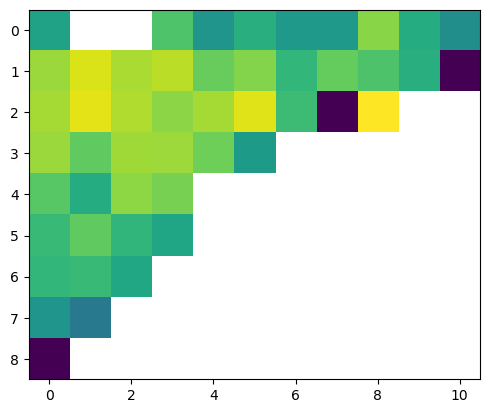

In [50]:
plt.imshow(diff_m_array)

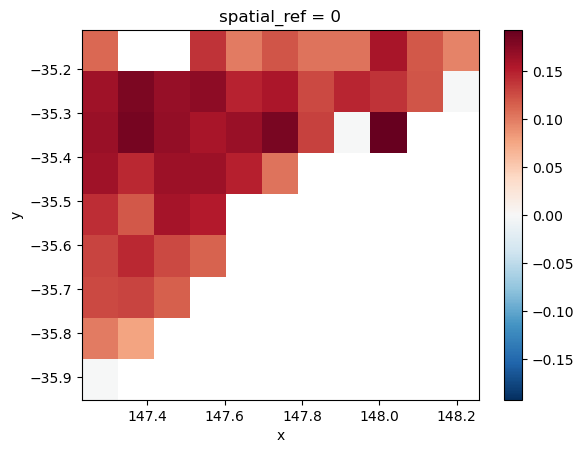

In [53]:
ds_diff_m = xr.DataArray(
            data = diff_m_array,
            dims=['y', 'x'],
            coords=dict(
                y = stacked_ds_SMAPL3_SM.y.values,
                x = stacked_ds_SMAPL3_SM.x.values
                )
        )
ds_diff_m.rio.write_crs('epsg:4326', inplace=True)
ds_diff_m.plot()
ds_diff_m.to_netcdf('test_diff_m.nc')

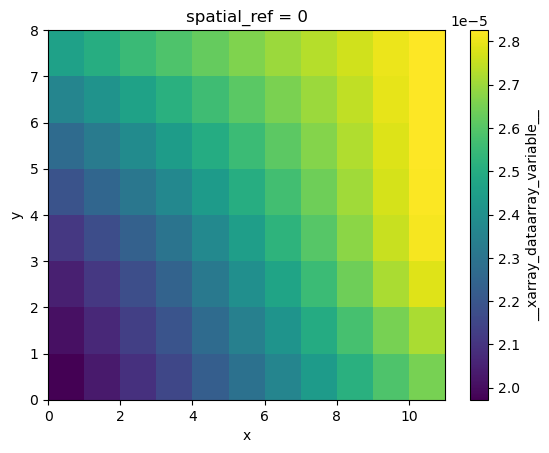

In [56]:
stacked_ds_SMAPL4_P.mean(dim='time', skipna=True).plot()

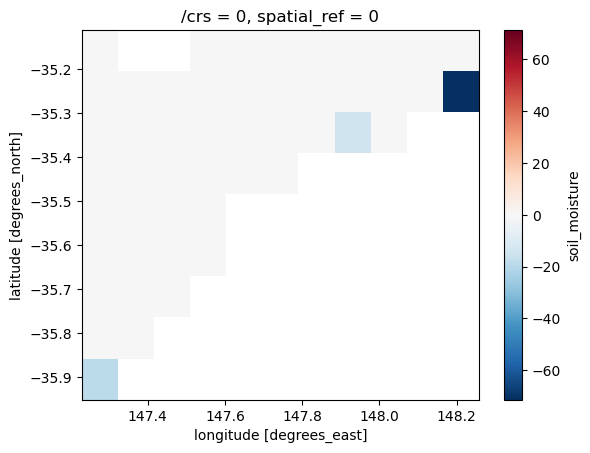

In [58]:
# stacked_ds_SMAPL3_SM.sel(time='2016-01-02').plot()
stacked_ds_SMAPL3_SM.mean(dim='time', skipna=True).plot()

In [34]:
# Linear regression Using Scikit learn
# forced_intercept = 0.02 # The minimum possible SMAP value [m3/m3] according to Akbar et al., (2018)
forced_intercept = df_synced['soil_moisture_smapL3'].min()
m_upper, b_upper = fit_linear_line(x=x_upper, y=y_upper, forced_intercept_x=forced_intercept, plot_results=False)
m_lower, b_lower = fit_linear_line(x=x_lower, y=y_lower, forced_intercept_x=forced_intercept, plot_results=False)


Text(0.5, 0.98, 'Oznet_Alabama_area: (147.29, -35.90, 148.17, -35.19)\nSlope upper-lower = 0.111')

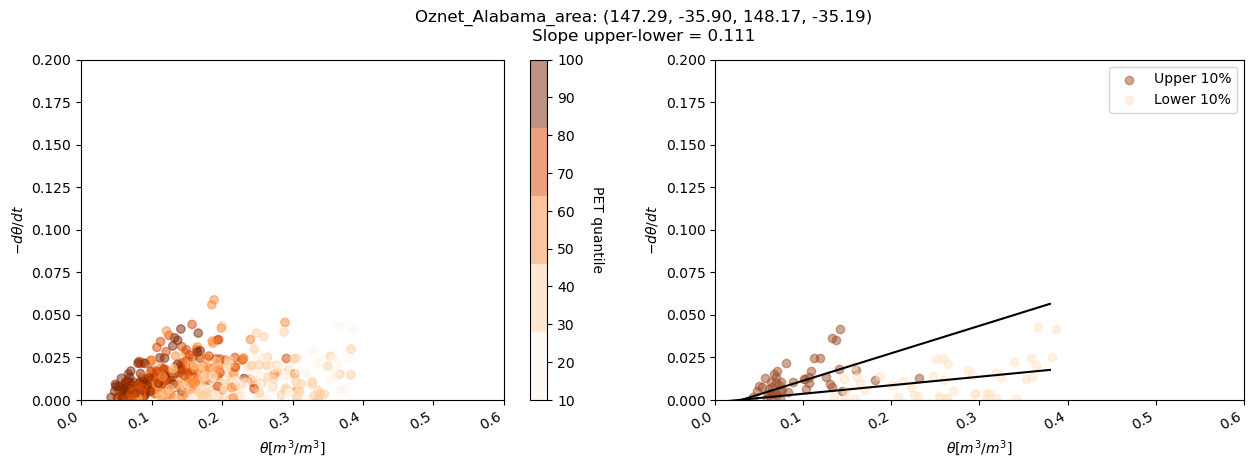

In [36]:

# %% [markdown]
## 2D plot  (PET as Z-axis)
# %%
from pylab import cm
smap_color = '#ff7f0e'
precip_color = '#779eb2'

label_SM = r"$\theta [m^3/m^3]$"
label_dSdt = r"$-d\theta/dt$"
label_lai = r"$LAI [m^2/m^2]$"
label_PET = r"$PET [mm/d]$"

title = f"{network_name}: ({minx:.2f}, {miny:.2f}, {maxx:.2f}, {maxy:.2f})\nSlope upper-lower = {m_upper[0]-m_lower[0]:.3f}"

fig = plt.figure(figsize=(15, 5))
fig.tight_layout(pad=5)
sm = df_synced['soil_moisture_smapL3'][df_synced['noprecip']].values
neg_dSdt = df_synced['dSdt(t+1)'][df_synced['noprecip']].values*-1
pet = df_synced['pet'][df_synced['noprecip']].values
pet_quantile = df_synced['PET_quantile'][df_synced['noprecip']].values
cmap_descrete = cm.get_cmap('Oranges', 5)

ax1 =  fig.add_subplot(1,2,1)
scatter = ax1.scatter(x=sm, y=neg_dSdt, c=pet_quantile, cmap= cmap_descrete, marker='o', alpha=0.5, label='SMAP L4')
xax = ax1.xaxis
# ax1.set_title(title)
ax1.set_xlabel(label_SM)
ax1.set_ylabel(label_dSdt)
ax1.set_xlim([0, 0.60])
ax1.set_ylim([0, 0.200])
cbar = plt.colorbar(scatter, ax=ax1)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("PET quantile", rotation=270)
fig.autofmt_xdate()

ax2 =  fig.add_subplot(1,2,2)

scatter1 = ax2.scatter(x=x_upper, y=y_upper, c='sienna', marker='o', alpha=0.5, label=f'Upper {quantile_thresh}%')
scatter2 = ax2.scatter(x=x_lower, y=y_lower, c='bisque', marker='o', alpha=0.5, label=f'Lower {quantile_thresh}%')
x_array = np.arange(0, max(x_lower), 0.01)
plt.plot(x_array, m_upper*x_array+b_upper, '-k')
plt.plot(x_array, m_lower*x_array+b_lower, '-k')
# plt.scatter(x_lower[~nans_lower], y_lower[~nans_lower], marker='o', s=50,facecolors='none',edgecolors='grey')
# plt.scatter(x_upper[~nans_upper], y_upper[~nans_upper], marker='o', s=50,facecolors='none',edgecolors='grey')
xax = ax2.xaxis
# ax2.set_title(title)
ax2.set_xlabel(label_SM)
ax2.set_ylabel(label_dSdt)
ax2.set_xlim([0, 0.60])
ax2.set_ylim([0, 0.200])
ax2.legend()
# cbar = plt.colorbar(scatter, ax=ax2)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel("PET quantile", rotation=270)
fig.autofmt_xdate()
fig.suptitle(title)


,soil_moisture_smapL3,precip,pet_x,x,y,spatial_ref,pet_y,noprecip,dt,dSdt,dSdt(t+1)
time,,,,,,,,,,,
2016-01-01,NaN,2.875219e-05,5.599757,147.299994,-35.2,0,5.599757,False,NaN,NaN,NaN
2016-01-02,0.097870,8.797576e-05,5.258338,147.299994,-35.2,0,5.258338,False,1.0,NaN,NaN
2016-01-03,0.165738,9.040076e-05,4.646394,147.299994,-35.2,0,4.646394,False,1.0,NaN,NaN
2016-01-05,0.169573,8.889216e-06,3.431496,147.299994,-35.2,0,3.431496,True,2.0,NaN,NaN
2016-01-06,0.171133,4.318474e-06,3.162811,147.299994,-35.2,0,3.162811,True,1.0,NaN,-0.019074
2016-01-08,0.132985,2.980689e-15,6.198416,147.299994,-35.2,0,6.198416,True,2.0,-0.019074,-0.015208
2016-01-10,0.102570,3.632158e-08,7.263088,147.299994,-35.2,0,7.263088,True,2.0,-0.015208,-0.006020
2016-01-11,0.096550,5.424851e-06,7.862807,147.299994,-35.2,0,7.862807,True,1.0,-0.006020,NaN
2016-01-13,0.106277,3.086579e-06,9.748232,147.299994,-35.2,0,9.748232,True,2.0,NaN,-0.009723


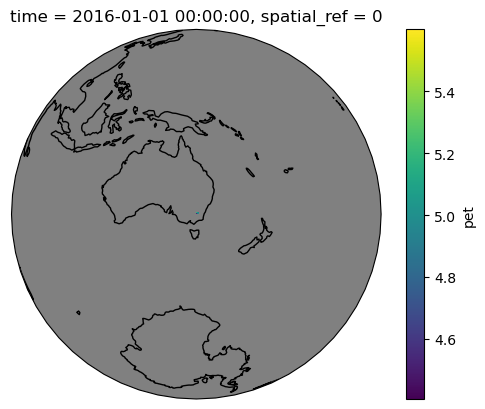

In [27]:
import cartopy.crs as ccrs

p = stacked_ds_PET.sel(time=startDate).plot(
    transform=ccrs.PlateCarree(),
    subplot_kws=dict(projection=ccrs.Orthographic(minx, miny), facecolor="gray")
)

p.axes.set_global()
p.axes.coastlines()

plt.draw()